# Fitbit Data Exploratory Analysis (EDA)

**Objective:**  
This analysis explores Fitbit smart device data to understand user activity, sleep, and calorie patterns.  
The goal is to identify key trends and insights that can support **Bellabeat’s marketing strategy** and help promote healthier lifestyle habits among users.


In [29]:
# Cell 1 — Setup
import os, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore', category=FutureWarning)
pd.set_option('display.max_columns', 200)
sns.set(style='whitegrid', context='notebook')

OUT_DIR  = os.path.join('files', 'fitness_result')
PLOT_DIR = os.path.join(OUT_DIR, 'plots')
os.makedirs(PLOT_DIR, exist_ok=True)
print('Output dir:', OUT_DIR)


Output dir: files\fitness_result


In [30]:
# Cell 2 — Load all CSVs (given names)
daily  = pd.read_csv('dailyActivity_merged.csv')
sleep  = pd.read_csv('sleepDay_merged.csv')
weight = pd.read_csv('weightLogInfo_merged.csv')
heart  = pd.read_csv('heartrate_seconds_merged.csv')
print('Loaded:', daily.shape, sleep.shape, weight.shape, heart.shape)


Loaded: (940, 15) (413, 5) (67, 8) (2483658, 3)


In [31]:
# Cell 3 — Normalize Id dtype
def norm_id(df):
    return df.assign(Id=pd.to_numeric(df['Id'], errors='coerce').astype('Int64').astype(str)) if 'Id' in df.columns else df

daily  = norm_id(daily)
sleep  = norm_id(sleep)
weight = norm_id(weight)
heart  = norm_id(heart)


In [32]:
# Cell 4 — Parse dates explicitly
# Daily
daily['ActivityDate'] = pd.to_datetime(daily['ActivityDate'], format='%m/%d/%Y', errors='coerce')
daily['date'] = daily['ActivityDate'].dt.normalize()

# Sleep
sleep['SleepDay'] = pd.to_datetime(sleep['SleepDay'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')
sleep['date'] = sleep['SleepDay'].dt.normalize()

# Weight (12h fallback 24h)
if 'Date' in weight.columns:
    try:
        weight['Date'] = pd.to_datetime(weight['Date'], format='%m/%d/%Y %I:%M:%S %p', errors='raise')
    except Exception:
        weight['Date'] = pd.to_datetime(weight['Date'], format='%m/%d/%Y %H:%M:%S', errors='coerce')

# Heart timestamp column
time_col = 'Time' if 'Time' in heart.columns else ('ActivitySecond' if 'ActivitySecond' in heart.columns else None)
if time_col is None:
    raise KeyError("Heart-rate file me 'Time' ya 'ActivitySecond' column nahi mila")
try:
    heart[time_col] = pd.to_datetime(heart[time_col], format='%m/%d/%Y %I:%M:%S %p', errors='raise')
except Exception:
    heart[time_col] = pd.to_datetime(heart[time_col], format='%m/%d/%Y %H:%M:%S', errors='coerce')
heart['date'] = heart[time_col].dt.normalize()


In [33]:
# Cell 5 — De-duplicate per Id+date
for d in [daily, sleep]:
    d.sort_values(['Id','date'], inplace=True)
    d.drop_duplicates(['Id','date'], keep='first', inplace=True)


In [34]:
# Cell 6 — Heart daily aggregation
hr_day = (heart.groupby(['Id','date'], as_index=False, observed=True)
            .agg(AvgHR=('Value','mean'),
                 MaxHR=('Value','max'),
                 MinHR=('Value','min'),
                 HRCount=('Value','size')))
hr_day[['AvgHR','MaxHR','MinHR']] = hr_day[['AvgHR','MaxHR','MinHR']].round(1)
print('hr_day:', hr_day.shape)


hr_day: (334, 6)


In [35]:
# Cell 7 — Build analysis df (merge sleep + HR)
cols_keep = ['Id','date','TotalSteps','Calories','SedentaryMinutes','VeryActiveMinutes','LightlyActiveMinutes']
df = daily[cols_keep].copy()

df = df.merge(sleep[['Id','date','TotalMinutesAsleep']], on=['Id','date'], how='left')
df = df.merge(hr_day, on=['Id','date'], how='left')

num_cols = ['TotalSteps','Calories','SedentaryMinutes','VeryActiveMinutes','LightlyActiveMinutes',
            'TotalMinutesAsleep','AvgHR','MaxHR','MinHR','HRCount']
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

df['weekday'] = df['date'].dt.day_name()
print('df:', df.shape)
df.head(2)


df: (940, 13)


,Id,date,TotalSteps,Calories,SedentaryMinutes,VeryActiveMinutes,LightlyActiveMinutes,TotalMinutesAsleep,AvgHR,MaxHR,MinHR,HRCount,weekday
0,1503960366,2016-04-12,13162,1985,728,25,328,327.0,NaN,NaN,NaN,NaN,Tuesday
1,1503960366,2016-04-13,10735,1797,776,21,217,384.0,NaN,NaN,NaN,NaN,Wednesday


In [36]:
# Cell 8 — QC flags and valid slice
cal_median = df['Calories'].median(skipna=True)
df['zero_step_high_cal'] = (df['TotalSteps']==0) & (df['Calories']>cal_median)
df['valid_row'] = ~df['zero_step_high_cal']
df_valid = df[df['valid_row']].copy()
print('valid rows:', df_valid.shape)


valid rows: (939, 15)


In [37]:
# Cell 10 — Step segments
bins = [-1, 5000, 10000, np.inf]
labels = ['<5k','5k-10k','>10k']
df_valid['steps_bucket'] = pd.cut(df_valid['TotalSteps'], bins=bins, labels=labels, include_lowest=True, ordered=True)

seg = (df_valid.groupby('steps_bucket', as_index=False, observed=True)
       .agg({'Calories':'mean','TotalMinutesAsleep':'mean','SedentaryMinutes':'mean','AvgHR':'mean'})
       .round(1))
seg


,steps_bucket,Calories,TotalMinutesAsleep,SedentaryMinutes,AvgHR
0,<5k,1804.0,454.3,1131.6,78.3
1,5k-10k,2355.2,422.1,956.1,77.5
2,>10k,2743.6,396.1,888.7,79.5


In [53]:
# Cell 11 — Save CSV outputs

def save_csv(obj, name):
    path = os.path.join(OUT_DIR, name)
    obj.to_csv(path, index=False, encoding='utf-8')
    return path

paths = {
    'clean_daily_sleep.csv': save_csv(df_valid, 'clean_daily_sleep.csv'),
    'agg_by_date.csv': save_csv(agg_by_date, 'agg_by_date.csv'),
    'agg_by_weekday.csv': save_csv(agg_by_weekday, 'agg_by_weekday.csv'),
    'segments_steps.csv': save_csv(seg, 'segments_steps.csv'),
    'heartrate_daily.csv': save_csv(hr_day, 'heartrate_daily.csv'),
}
paths


{'clean_daily_sleep.csv': 'files\\fitness_result\\clean_daily_sleep.csv',
 'agg_by_date.csv': 'files\\fitness_result\\agg_by_date.csv',
 'agg_by_weekday.csv': 'files\\fitness_result\\agg_by_weekday.csv',
 'segments_steps.csv': 'files\\fitness_result\\segments_steps.csv',
 'heartrate_daily.csv': 'files\\fitness_result\\heartrate_daily.csv'}

In [54]:
# Cell 12 — KPIs for Markdown

avg_steps = int(df_valid['TotalSteps'].mean())
pct_10k = round((df_valid['TotalSteps']>=10000).mean()*100, 1)
avg_sleep = int(df_valid['TotalMinutesAsleep'].mean())
avg_sedentary = int(df_valid['SedentaryMinutes'].mean())
avg_hr = round(df_valid['AvgHR'].mean(),1) if 'AvgHR' in df_valid.columns else None
top_weekday = df_valid.groupby('weekday', observed=True)['TotalSteps'].mean().idxmax()
low_weekday = df_valid.groupby('weekday', observed=True)['TotalSteps'].mean().idxmin()


In [55]:
# Cell 13A — Setup for plotting

try:
    get_ipython().run_line_magic('matplotlib', 'inline')
except:
    pass

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', context='notebook')

def save_and_show(fig, name):
    path = os.path.join(PLOT_DIR, name)
    fig.tight_layout()
    fig.savefig(path, dpi=150)
    plt.show()
    plt.close(fig)
    return path

print('Plot dir:', PLOT_DIR)


Plot dir: files\fitness_result\plots


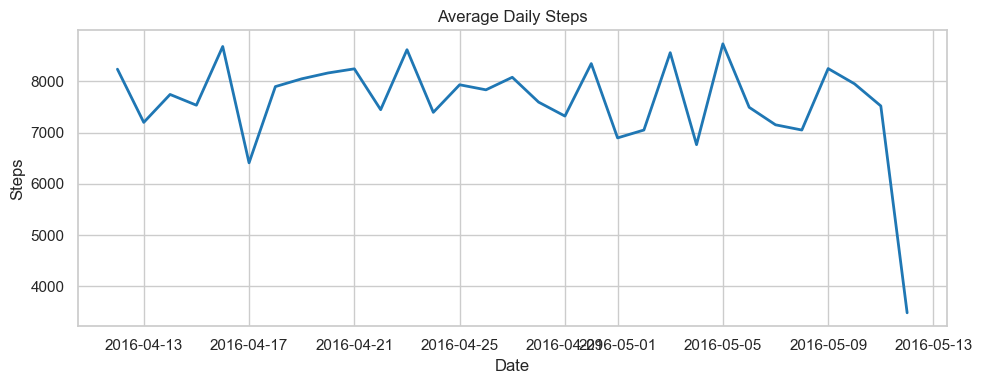

'files\\fitness_result\\plots\\steps_over_time.png'

In [56]:
# Cell 13B — Steps over time
fig, ax = plt.subplots(figsize=(10,4))
tmp = agg_by_date.sort_values('date')
ax.plot(tmp['date'], tmp['TotalSteps'], color='#1f77b4', linewidth=2)
ax.set_title('Average Daily Steps'); ax.set_xlabel('Date'); ax.set_ylabel('Steps')
save_and_show(fig, 'steps_over_time.png')


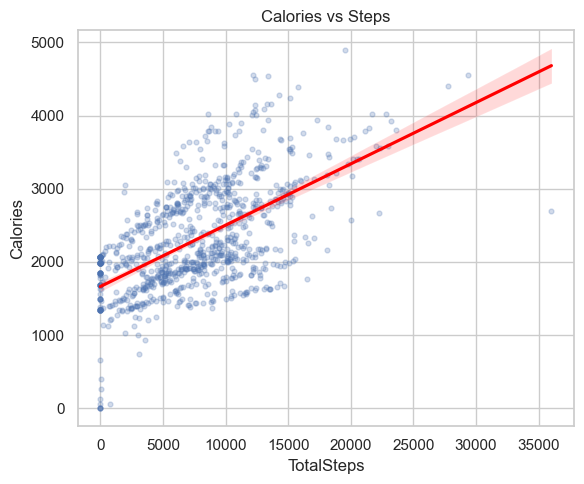

'files\\fitness_result\\plots\\calories_vs_steps.png'

In [57]:
# Cell 13C — Calories vs Steps

fig, ax = plt.subplots(figsize=(6,5))
samp = df_valid.sample(min(3000, len(df_valid)), random_state=42) if len(df_valid)>0 else df_valid
sns.regplot(data=samp, x='TotalSteps', y='Calories',
            scatter_kws={'alpha':0.25, 's':12}, line_kws={'color':'red'}, ax=ax)
ax.set_title('Calories vs Steps')
save_and_show(fig, 'calories_vs_steps.png')


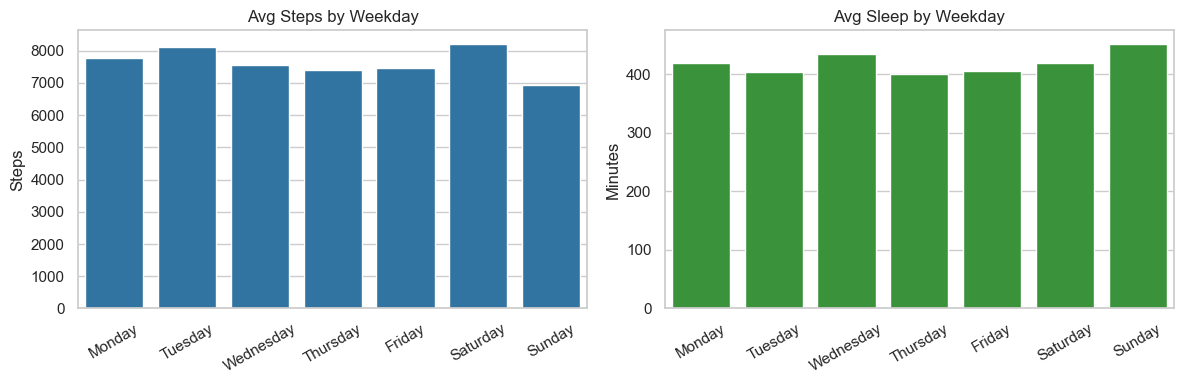

'files\\fitness_result\\plots\\weekday_bars.png'

In [58]:
# Cell 13D — Weekday bars (Steps, Sleep)

order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
tmp_w = agg_by_weekday.set_index('weekday').reindex(order).reset_index()

fig, ax = plt.subplots(1,2,figsize=(12,4), sharex=True)
sns.barplot(data=tmp_w, x='weekday', y='TotalSteps', ax=ax[0], color='#1f77b4')
ax[0].set_title('Avg Steps by Weekday'); ax[0].set_xlabel(''); ax[0].set_ylabel('Steps'); ax[0].tick_params(axis='x', rotation=30)
sns.barplot(data=tmp_w, x='weekday', y='TotalMinutesAsleep', ax=ax[1], color='#2ca02c')
ax[1].set_title('Avg Sleep by Weekday'); ax[1].set_xlabel(''); ax[1].set_ylabel('Minutes'); ax[1].tick_params(axis='x', rotation=30)
save_and_show(fig, 'weekday_bars.png')


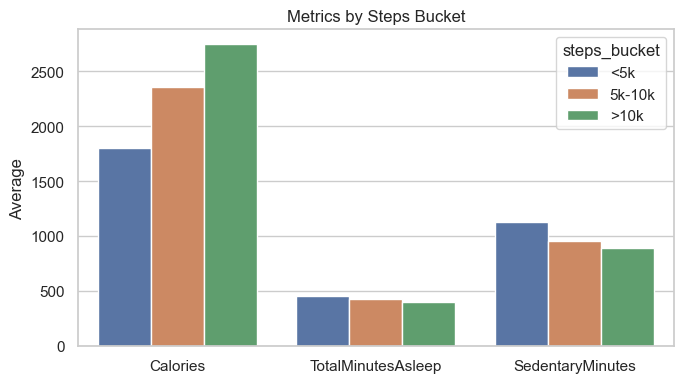

'files\\fitness_result\\plots\\segments_compare.png'

In [59]:
# Cell 13E — Segments comparison

melt_cols = [c for c in ['Calories','TotalMinutesAsleep','SedentaryMinutes'] if c in seg.columns]
m = seg.melt(id_vars='steps_bucket', value_vars=melt_cols, var_name='Metric', value_name='Value') if len(seg)>0 else seg

fig, ax = plt.subplots(figsize=(7,4))
if len(m)>0:
    sns.barplot(data=m, x='Metric', y='Value', hue='steps_bucket', ax=ax)
    ax.set_title('Metrics by Steps Bucket'); ax.set_xlabel(''); ax.set_ylabel('Average')
else:
    ax.text(0.5,0.5,'No segment data', ha='center')
save_and_show(fig, 'segments_compare.png')


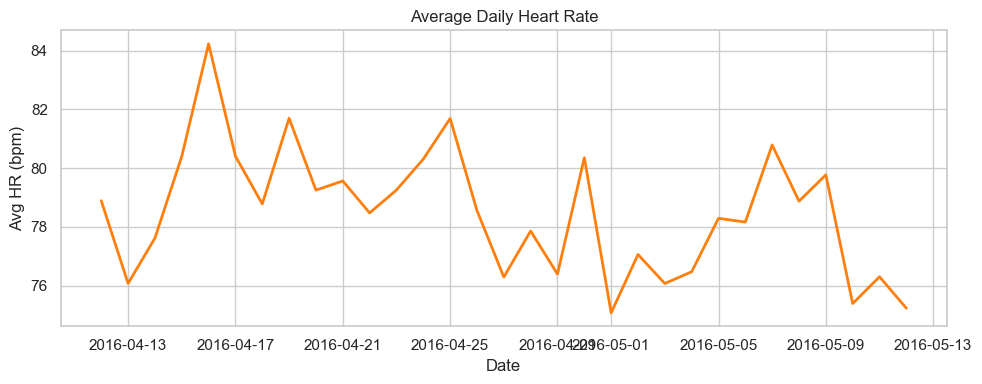

In [60]:
# Cell 13F — Average HR over time

if 'AvgHR' in agg_by_date.columns and not agg_by_date['AvgHR'].isna().all():
    fig, ax = plt.subplots(figsize=(10,4))
    t = agg_by_date.sort_values('date')
    ax.plot(t['date'], t['AvgHR'], color='#ff7f0e', linewidth=2)
    ax.set_title('Average Daily Heart Rate'); ax.set_xlabel('Date'); ax.set_ylabel('Avg HR (bpm)')
    save_and_show(fig, 'avg_hr_over_time.png')
else:
    print('AvgHR not available to plot')


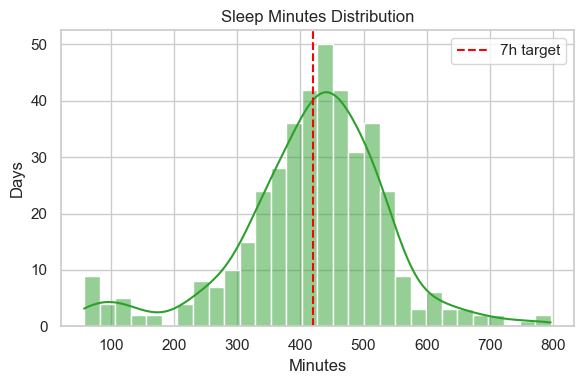

'files\\fitness_result\\plots\\sleep_distribution.png'

In [61]:
# Cell 13G — Sleep distribution

fig, ax = plt.subplots(figsize=(6,4))
if 'TotalMinutesAsleep' in df_valid.columns and df_valid['TotalMinutesAsleep'].notna().any():
    sns.histplot(df_valid['TotalMinutesAsleep'].dropna(), bins=30, kde=True, color='#2ca02c', ax=ax)
    ax.axvline(420, color='red', linestyle='--', label='7h target'); ax.legend()
    ax.set_title('Sleep Minutes Distribution'); ax.set_xlabel('Minutes'); ax.set_ylabel('Days')
else:
    ax.text(0.5,0.5,'No sleep data', ha='center')
save_and_show(fig, 'sleep_distribution.png')


# Fitbit Wellness Analysis
Cohort daily activity, sleep, and heart‑rate exploration with clean pipeline, quality checks, visuals, and actionable insights.


In [62]:
from IPython.display import Markdown, display
dup_daily = daily.duplicated(['Id','date']).sum()
dup_sleep = sleep.duplicated(['Id','date']).sum()
missing_sleep_rows = int(df['TotalMinutesAsleep'].isna().sum())
zero_high_cal = int(df['zero_step_high_cal'].sum())

display(Markdown(f"""
## Data Quality Notes

- Sources: dailyActivity, sleepDay, weightLogInfo, heartrate_seconds (merged at Id+date).
- Types & ranges: Id as string; dates normalized to day boundaries.
- Cleaning: Explicit datetime parsing, Id normalization, Id+date de-dup, anomaly flag.

### Checks & Findings
- Duplicates removed: {dup_daily} in daily, {dup_sleep} in sleep.
- Missing values: Sleep minutes missing on {missing_sleep_rows} rows; HR missing where no wear/recording.
- Anomalies: {zero_high_cal} zero-step but high-calorie rows flagged and excluded from analysis.
- Assumptions: Non-wear days excluded for aggregates; results interpreted accordingly.
"""))



## Data Quality Notes

- Sources: dailyActivity, sleepDay, weightLogInfo, heartrate_seconds (merged at Id+date).
- Types & ranges: Id as string; dates normalized to day boundaries.
- Cleaning: Explicit datetime parsing, Id normalization, Id+date de-dup, anomaly flag.

### Checks & Findings
- Duplicates removed: 0 in daily, 0 in sleep.
- Missing values: Sleep minutes missing on 530 rows; HR missing where no wear/recording.
- Anomalies: 1 zero-step but high-calorie rows flagged and excluded from analysis.
- Assumptions: Non-wear days excluded for aggregates; results interpreted accordingly.


In [63]:
display(Markdown(f"""
## Key Insights

- Usage snapshot: Avg steps ≈ {avg_steps}, ~{pct_10k}% days ≥10k; avg sleep ≈ {avg_sleep} min; sedentary ≈ {avg_sedentary} min; avg HR ≈ {avg_hr}.
- Activity–calories: Clear positive relationship between steps and calories; higher activity correlates with improved sedentary profile.
- Weekly rhythm: Highest steps on {top_weekday}, lowest on {low_weekday}; timing opportunities for nudges.
- Sleep: Distribution shows a sizeable share < 420 min; scope for sleep habit improvement.

## Recommendations

- Adaptive nudges: Afternoon short‑walk reminders and 10‑min mini‑goals on high‑sedentary days.
- Weekday challenges: Micro‑challenges on {low_weekday}; sustain gains from {top_weekday} into weekends.
- Sleep coaching: If sleep < 7h, offer wind‑down tips and next‑day gentle‑activity plans.
- Personalization: Step‑bucket programs (<5k beginners, 5k‑10k progress, >10k intensity mix) and HR‑aware guidance.
- Data quality: Maintain wear‑detection filter; encourage consistent logging for sleep/HR completeness.
"""))



## Key Insights

- Usage snapshot: Avg steps ≈ 7646, ~32.3% days ≥10k; avg sleep ≈ 419 min; sedentary ≈ 990 min; avg HR ≈ 78.6.
- Activity–calories: Clear positive relationship between steps and calories; higher activity correlates with improved sedentary profile.
- Weekly rhythm: Highest steps on Saturday, lowest on Sunday; timing opportunities for nudges.
- Sleep: Distribution shows a sizeable share < 420 min; scope for sleep habit improvement.

## Recommendations

- Adaptive nudges: Afternoon short‑walk reminders and 10‑min mini‑goals on high‑sedentary days.
- Weekday challenges: Micro‑challenges on Sunday; sustain gains from Saturday into weekends.
- Sleep coaching: If sleep < 7h, offer wind‑down tips and next‑day gentle‑activity plans.
- Personalization: Step‑bucket programs (<5k beginners, 5k‑10k progress, >10k intensity mix) and HR‑aware guidance.
- Data quality: Maintain wear‑detection filter; encourage consistent logging for sleep/HR completeness.


In [64]:
print(OUT_DIR); print(PLOT_DIR); os.getcwd()


files\fitness_result
files\fitness_result\plots


'C:\\Users\\DELL'

In [65]:
import glob, os
print(glob.glob(os.path.join(OUT_DIR, '*.csv')))
print(glob.glob(os.path.join(PLOT_DIR, '*.png')))


['files\\fitness_result\\agg_by_date.csv', 'files\\fitness_result\\agg_by_weekday.csv', 'files\\fitness_result\\clean_daily_sleep.csv', 'files\\fitness_result\\heartrate_daily.csv', 'files\\fitness_result\\segments_steps.csv']
['files\\fitness_result\\plots\\avg_hr_over_time.png', 'files\\fitness_result\\plots\\calories_vs_steps.png', 'files\\fitness_result\\plots\\sedentary_vs_steps.png', 'files\\fitness_result\\plots\\segments_compare.png', 'files\\fitness_result\\plots\\sleep_distribution.png', 'files\\fitness_result\\plots\\steps_over_time.png', 'files\\fitness_result\\plots\\weekday_bars.png']


# Final Insights

From the exploratory analysis of Fitbit smart device data, the following key patterns were observed:

- **Activity & Calories** → Users with higher daily steps and active minutes burn significantly more calories.  
- **Sleep & Activity Balance** → Longer sleep duration often corresponds with fewer active minutes, suggesting an inverse relationship.  
- **User Engagement** → Many users show irregular activity patterns, with big differences across days, indicating inconsistent engagement.  
- **Health Implications** → Consistent daily steps and balanced sleep appear to be the strongest factors for a healthier lifestyle.

📊 These insights can help **Bellabeat** by:  
- Sending reminders for daily step goals,  
- Providing notifications for balanced sleep schedules, and  
- Running targeted campaigns promoting consistent activity habits.
